# SCFT Computation with Cylinderical Phase

<!-- This example demonstrates how to find the saddle-point solution of AB diblock copolymer systems with Anderson Mixing. -->
1. Fields are efficiently updated using the Anderson Mixing

2. This example computes the stress residuals to determine the box size that minimizes the free energy: 
\begin{align}
{\bf R}_{stress} = − \frac{1}{Q}\frac{\partial Q}{\partial \boldsymbol\theta}
\end{align}
where $\boldsymbol\theta = [L_x, L_y, L_z]^{T}$ is a vector of unit-cell parameters.

3. This example uses pre-written `scft.py` located in \${PYTHON_SITE_PACKAGES}\$/polymerfts

References:
* [Accelerating self-consistent field theory of block polymers in a variable unit cell](http://dx.doi.org/10.1063/1.4986643)
* [Fast and accurate SCFT calculations for periodic block-copolymer morphologies using the spectral method with Anderson mixing](http://dx.doi.org/10.1140/epje/i2009-10534-3)
* [Efficiency of pseudo-spectral algorithms with Anderson mixing for the SCFT of periodic block-copolymer phases](http://dx.doi.org/10.1140/epje/i2011-11110-0)

### 1. Setting simulation parameters 

In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.io import savemat, loadmat
from scipy.ndimage import gaussian_filter
from polymerfts import scft

# OpenMP environment variables
os.environ["OMP_MAX_ACTIVE_LEVELS"] = "1"  # 0, 1
os.environ["OMP_NUM_THREADS"] = "2"  # 1 ~ 4

# Major Simulation params
f = 1.0/3.0     # A-fraction of major BCP chain, f

params = {
    # "platform":"cuda",           # choose platform among [cuda, cpu-mkl]
    
    "nx":[48,32],                        # Simulation grid numbers
    "lx":[2.4,1.8],  # Simulation box size as a_Ref * N_Ref^(1/2) unit,
                                            # where "a_Ref" is reference statistical segment length
                                            # and "N_Ref" is the number of segments of reference linear homopolymer chain.

    "reduce_gpu_memory_usage":False, # Reduce gpu memory usage by storing propagators in main memory instead of gpu memory.
    "box_is_altering":True,     # Find box size that minimizes the free energy during saddle point iteration.
    "chain_model":"discrete",   # "discrete" or "continuous" chain model
    "ds":1/90,                  # Contour step interval, which is equal to 1/N_Ref.

    "segment_lengths":{         # Relative statistical segment length compared to "a_Ref.
        "A":1.0, 
        "B":1.0, },

    "chi_n": {"A,B": 15},       # Interaction parameter, Flory-Huggins params * N_Ref

    "distinct_polymers":[{      # Distinct Polymers
        "volume_fraction":1.0,  # volume fraction of polymer chain
        "blocks":[              # AB diBlock Copolymer
            {"type":"A", "length":f, }, # A-block
            {"type":"B", "length":1-f}, # B-block
        ],},],

    "optimizer":{
        "name":"am",            # Anderson Mixing
        "max_hist":20,          # Maximum number of history
        "start_error":1e-2,     # When switch to AM from simple mixing
        "mix_min":0.1,          # Minimum mixing rate of simple mixing
        "mix_init":0.1,         # Initial mixing rate of simple mixing
    },

    "max_iter":2000,     # The maximum relaxation iterations
    "tolerance":1e-8     # Terminate iteration if the self-consistency error is less than tolerance
}

### 2. Initial potential fields

w_A and w_B are initialized to cylindrical phase.


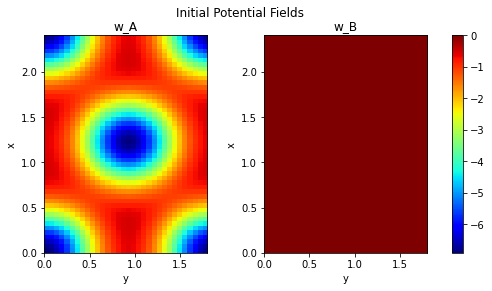

In [2]:
nx = params["nx"]
lx = params["lx"]

# Set initial fields
w_A = np.zeros(list(params["nx"]), dtype=np.float64)
w_B = np.zeros(list(params["nx"]), dtype=np.float64)
print("w_A and w_B are initialized to cylindrical phase.")
cylinder_positions = [
[0.0,0.0],[1/2,1/2],]
for x,y in cylinder_positions:
    mx, my = np.round((np.array([x, y])*params["nx"])).astype(np.int32)
    w_A[mx,my] = -5/(np.prod(params["lx"])/np.prod(params["nx"]))
w_A = gaussian_filter(w_A, sigma=np.min(params["nx"])/5, mode='wrap')

w = {"A": w_A, "B": w_B}  # potential field dictionary

# Plot each image with the same vmin and vmax
vmin = min(w_A.min(), w_B.min())
vmax = max(w_A.max(), w_B.max())

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
fig.suptitle("Initial Potential Fields")
im = axes[0].imshow(w_A[:,:], extent=(0, lx[1], 0, lx[0]), origin='lower', cmap=cm.jet, vmin=vmin, vmax=vmax)
im = axes[1].imshow(w_B[:,:], extent=(0, lx[1], 0, lx[0]), origin='lower', cmap=cm.jet, vmin=vmin, vmax=vmax)
axes[0].set(title='w_A', xlabel='y', ylabel='x')
axes[1].set(title='w_B', xlabel='y', ylabel='x')

fig.subplots_adjust(right=1.0)
fig.colorbar(im, ax=axes.ravel().tolist())
fig.show()

### 3. Initialization

One of eigenvalues is zero for given chiN values.
========== CUDA Setting and Device Information ==========
N_BLOCKS, N_THREADS: 256, 256
DeviceCount (# of available GPUs): 4
Device 0: 				NVIDIA A10
Compute capability version: 		8.6
Multiprocessor: 			72
Global memory: 				22502 MBytes
Constant memory: 			65536 Bytes
Shared memory per block: 		49152 Bytes
Registers available per block: 		65536
Warp size: 				32
Maximum threads per block: 		1024
Max size of a thread block (x,y,z): 	(1024, 1024, 64)
Max size of a grid size    (x,y,z): 	(2147483647, 65535, 65535)
Device overlap: 			Yes
------------ Polymer Field Theory for Multimonomer ------------
Eigenvalues:
	 [-15.   0.]
Eigenvectors [v1, v2, ...] :
	 [[ 1.  1.]
	 [-1.  1.]]
Mapping matrix A:
	 [[ 1.  1.]
	 [-1.  1.]]
Real Fields:  [0]
Imaginary Fields:  [1]
In Hamiltonian:
	reference energy:  3.75
	coefficients of int of mu(r)/V:  [-0. -1.]
	coefficients of int of mu(r)^2/V:  [0.06666667 0.        ]
	dH_ref/dχN:  {'A,B': 0.249999999

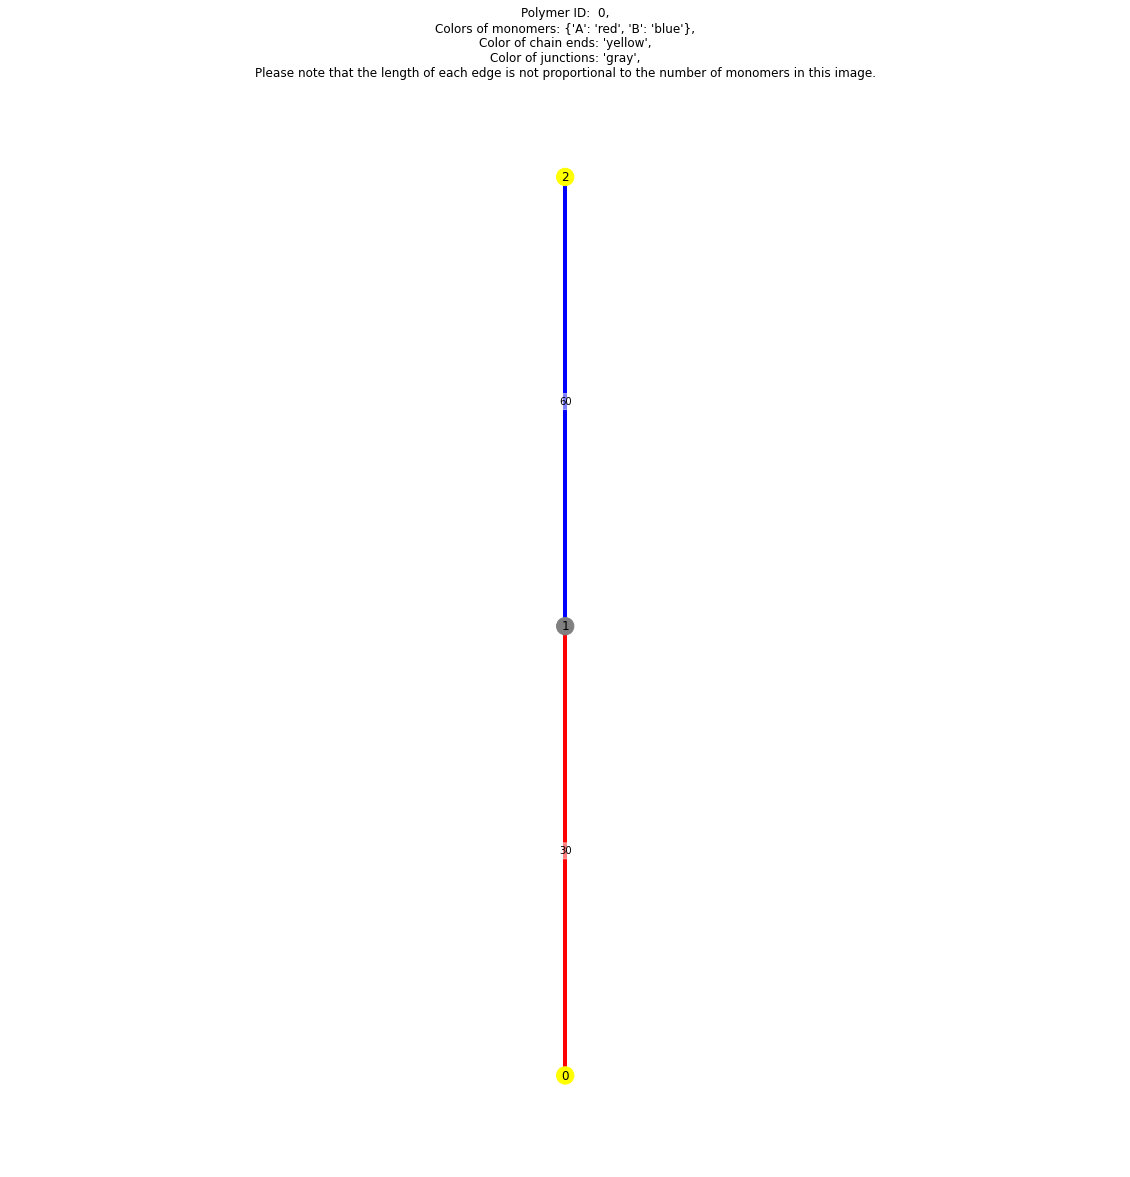

In [3]:
# Initialize calculation
calculation = scft.SCFT(params=params)

### 4. Run

In [4]:
# Run
calculation.run(initial_fields={"A": w_A, "B": w_B})

---------- Run ----------
iteration, mass error, total_partitions, energy_total, error_level, box size
       1   -6.108E-16  [ 1.1360086E+00  ]    -0.079735537   1.6603908E+00  [  2.4000000, 1.8000000 ]
       2    1.416E-14  [ 1.0855029E+00  ]    -0.039026176   1.2228642E+00  [  2.4019552, 1.8023108 ]
       3    1.354E-14  [ 1.0635675E+00  ]    -0.021094031   8.7842601E-01  [  2.4028003, 1.8031295 ]


       4    1.641E-14  [ 1.0536527E+00  ]    -0.012894682   6.1799778E-01  [  2.4031693, 1.8033201 ]
       5    2.195E-14  [ 1.0492962E+00  ]    -0.009095694   4.2969988E-01  [  2.4033221, 1.8032349 ]
       6    1.194E-14  [ 1.0476929E+00  ]    -0.007362067   2.9897833E-01  [  2.4033732, 1.8030250 ]
       7    1.540E-14  [ 1.0475394E+00  ]    -0.006624434   2.1456474E-01  [  2.4033752, 1.8027565 ]
       8   -1.491E-14  [ 1.0482008E+00  ]    -0.006378254   1.6715764E-01  [  2.4033533, 1.8024579 ]
       9    6.448E-15  [ 1.0493565E+00  ]    -0.006380671   1.4679269E-01  [  2.4033193, 1.8021410 ]
      10    1.522E-14  [ 1.0508398E+00  ]    -0.006513243   1.4226146E-01  [  2.4032792, 1.8018099 ]
      11   -1.950E-14  [ 1.0525619E+00  ]    -0.006717780   1.4458934E-01  [  2.4032355, 1.8014656 ]
      12   -2.647E-15  [ 1.0542749E+00  ]    -0.006939224   1.4836661E-01  [  2.4031943, 1.8011445 ]
      13    1.411E-15  [ 1.0561051E+00  ]    -0.007182471   1.5218174E-01  [  2.4031519, 1.

### 5. Display the results

Box size: [2.7749415270723126, 1.6021132011226442]


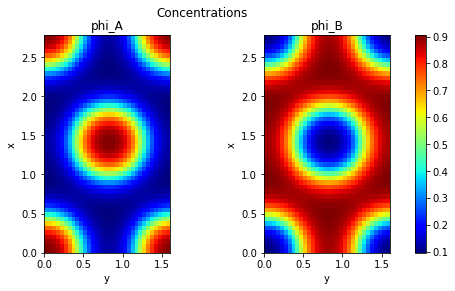

In [5]:
# Get the box size
lx = calculation.cb.get_lx()
print("Box size:", lx)

# Get the ensemble average concentration for each monomer type
phi_A = np.reshape(calculation.phi["A"], nx)
phi_B = np.reshape(calculation.phi["B"], nx)

# Plot each image with the same vmin and vmax
vmin = min(phi_A.min(), phi_B.min())
vmax = max(phi_A.max(), phi_B.max())

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
fig.suptitle("Concentrations")
im = axes[0].imshow(phi_A, extent=(0, lx[1], 0, lx[0]), origin='lower', cmap=cm.jet, vmin=vmin, vmax=vmax)
im = axes[1].imshow(phi_B, extent=(0, lx[1], 0, lx[0]), origin='lower', cmap=cm.jet, vmin=vmin, vmax=vmax)
axes[0].set(title='phi_A', xlabel='y', ylabel='x')
axes[1].set(title='phi_B', xlabel='y', ylabel='x')

fig.subplots_adjust(right=1.0)
fig.colorbar(im, ax=axes.ravel().tolist())
fig.show()


### 6. Save the results

In [6]:
# Save final results (.mat, .json or .yaml format)
calculation.save_results("fields.json")

# Recording first a few iteration results for debugging and refactoring
    #    1   -8.105E-15  [ 1.0111950E+00  ]    -0.005550595   1.4459112E+00  [  3.3000000, 3.3000000, 3.3000000 ]
    #    2   -5.329E-15  [ 1.0120871E+00  ]    -0.005274676   1.0819658E+00  [  3.3000217, 3.3000217, 3.3000217 ]
    #    3   -1.554E-15  [ 1.0136595E+00  ]    -0.005598893   8.8631268E-01  [  3.3000287, 3.3000287, 3.3000287 ]
    #    4   -8.660E-15  [ 1.0156725E+00  ]    -0.006242039   7.8452381E-01  [  3.3000282, 3.3000282, 3.3000282 ]
    #    5   -2.331E-15  [ 1.0180636E+00  ]    -0.007097169   7.3177360E-01  [  3.3000234, 3.3000234, 3.3000234 ]